In [50]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix
%load_ext tensorboard



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/tflite_models/bloodcells_dataset.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_44875.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_448776.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_449730.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_449915.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_450464.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_451701.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_451729.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_453088.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_454089.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_454943.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_455080.jpg  
  inflating: /content/dataset/bloodcells_dataset/neutrophil/BNE_4555.jpg  
  inflating: /content/datase

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = "/content/dataset/bloodcells_dataset"
data_dirs = "/content/dataset/bloodcells_dataset"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dirs,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


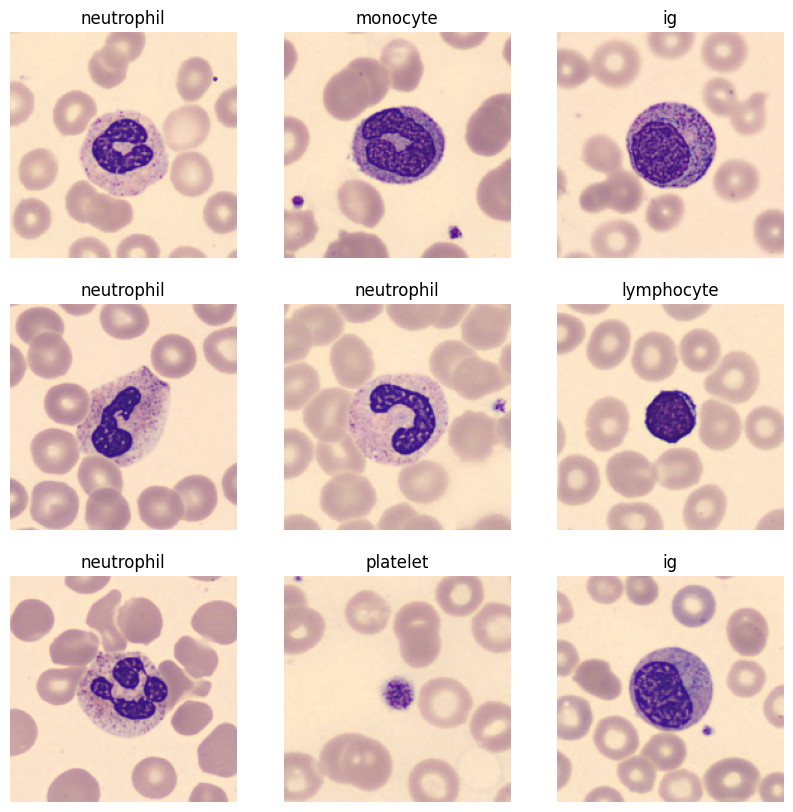

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.041340012 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

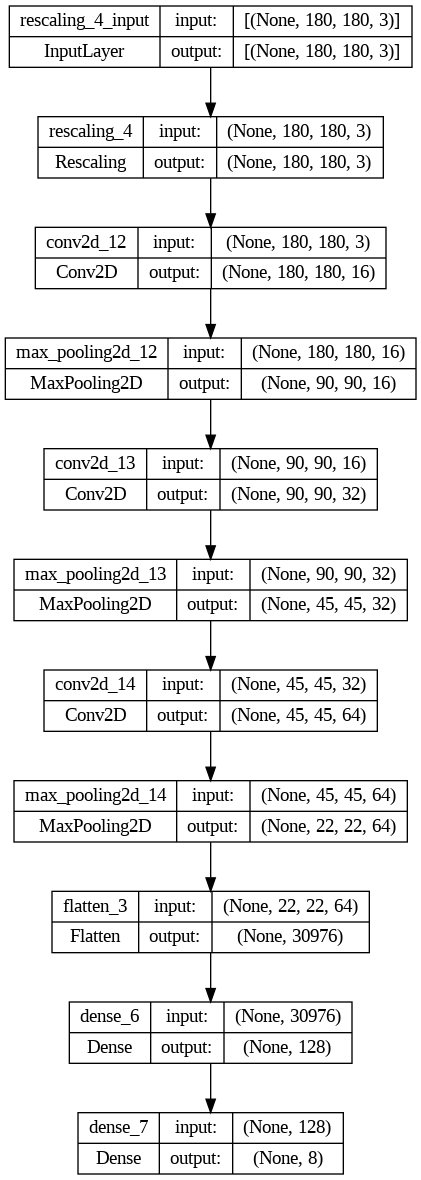

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
428/428 [==============================] - 11s 21ms/step - loss: 0.9188 - accuracy: 0.6659 - val_loss: 0.4154 - val_accuracy: 0.8505
Epoch 2/25
428/428 [==============================] - 10s 23ms/step - loss: 0.3424 - accuracy: 0.8798 - val_loss: 0.3063 - val_accuracy: 0.9005
Epoch 3/25
428/428 [==============================] - 10s 23ms/step - loss: 0.2460 - accuracy: 0.9137 - val_loss: 0.2328 - val_accuracy: 0.9242
Epoch 4/25
428/428 [==============================] - 9s 21ms/step - loss: 0.1914 - accuracy: 0.9340 - val_loss: 0.2347 - val_accuracy: 0.9201
Epoch 5/25
428/428 [==============================] - 10s 22ms/step - loss: 0.1542 - accuracy: 0.9462 - val_loss: 0.2926 - val_accuracy: 0.8903
Epoch 6/25
428/428 [==============================] - 9s 21ms/step - loss: 0.1206 - accuracy: 0.9571 - val_loss: 0.2141 - val_accuracy: 0.9324
Epoch 7/25
428/428 [==============================] - 9s 22ms/step - loss: 0.1039 - accuracy: 0.9640 - val_loss: 0.2483 - val_accuracy: 0.

In [ ]:
y_probs = model.predict(val_ds)
y_preds = y_probs.argmax(axis=1)
y_preds

107/107 [==============================] - 1s 10ms/step


array([3, 3, 7, ..., 6, 6, 6])

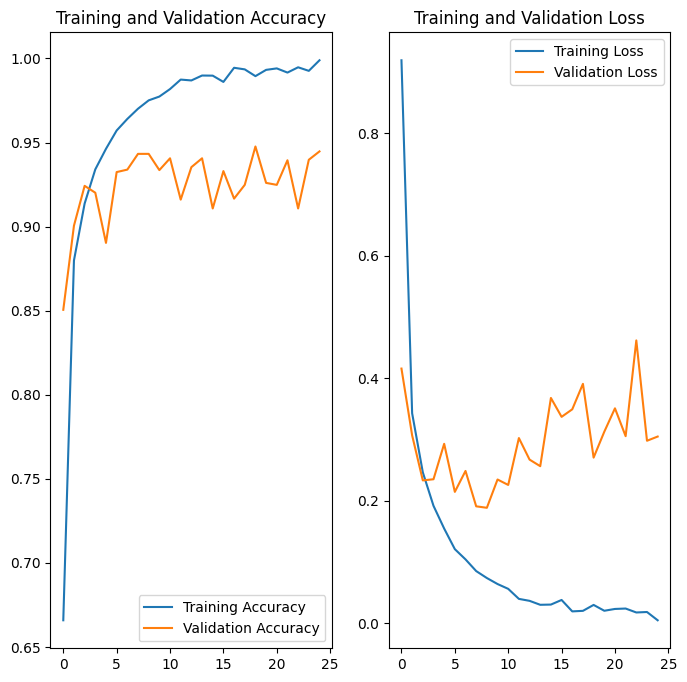

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

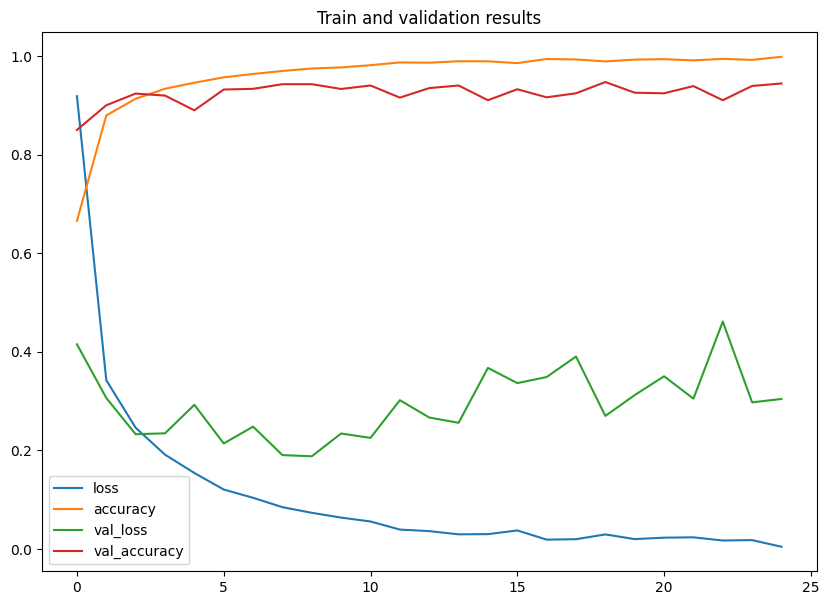

In [48]:
pd.DataFrame(history.history).plot(title="Train and validation results",figsize=(10,7));

In [58]:
img_path = "/content/dataset/bloodcells_dataset/ig/IG_132866.jpg"
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])



1/1 [==============================] - 0s 23ms/step


ig


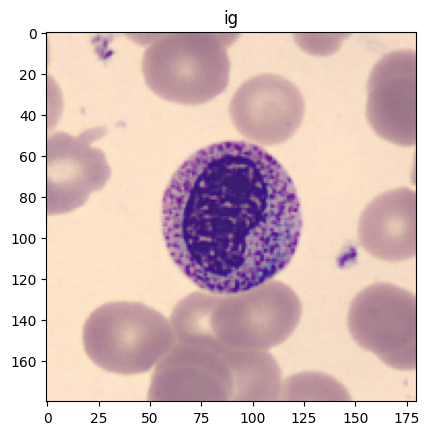

In [63]:
plt.title(class_names[np.argmax(score)])
plt.imshow(images[i].numpy().astype("uint8"))
print(class_names[np.argmax(score)])
#plt.axis('off')

1/1 [==============================] - 0s 21ms/step


<ipython-input-68-95e42739a8fd>:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, n)


1/1 [==============================] - 0s 22ms/step


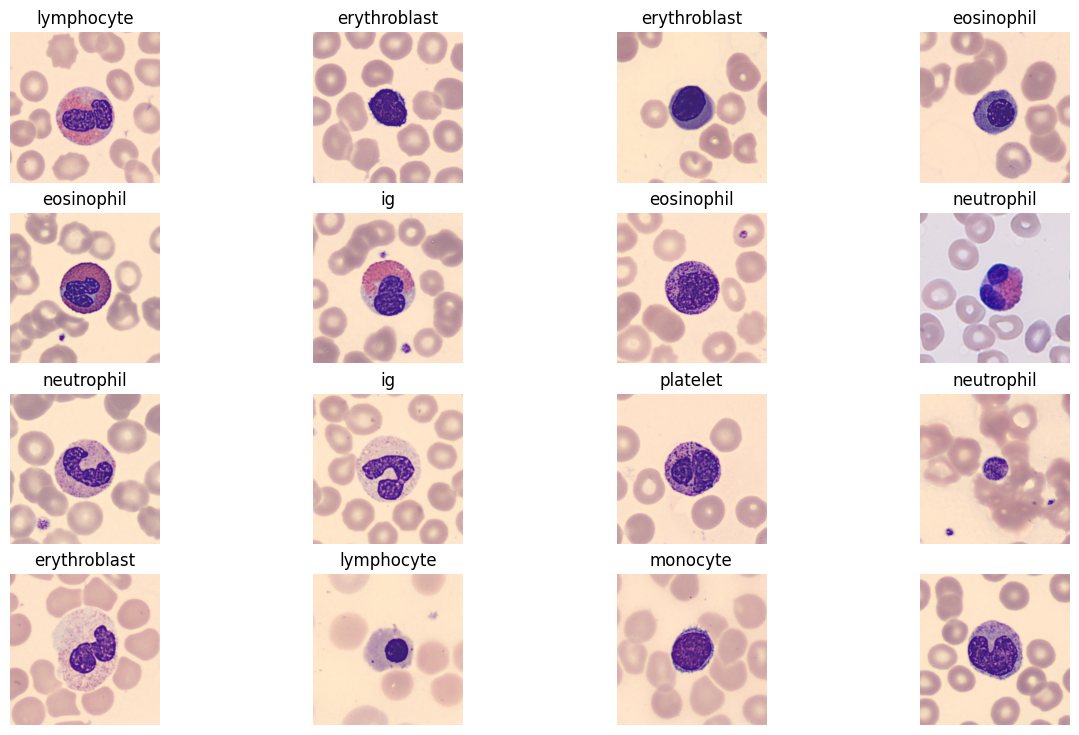

In [68]:
import random
from PIL import Image
import os

def predict(imgs):
  img = tf.keras.utils.load_img(
  imgs, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  return class_names[np.argmax(score)]


images = []
for folder in os.listdir("/content/dataset/bloodcells_dataset"):
  for image in os.listdir("/content/dataset/bloodcells_dataset" + '/' + folder):
    images.append(os.path.join("/content/dataset/bloodcells_dataset", folder, image))

plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = plt.imread(random_img)
  plt.title(predict(random_img))
  plt.subplot(4, 4, n)
  plt.axis('off')
  plt.imshow(imgs)

plt.show()
